In [29]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# Functions for computing primal gaps and CPI

def primal_gap(f_opt, f_curr):
    if f_opt == 0 and f_curr == 0:
        return 0
    elif f_opt * f_curr < 0:
        return 1
    else:
        return abs(f_opt - f_curr) / max(abs(f_opt), abs(f_curr))

def compute_primal_gaps(f_opt, objectives):
    return [primal_gap(f_opt, f) for f in objectives]

def compute_primal_gap_function(t_max, times, primal_gaps):
    primal_gap_function = [(0, 1)]  # Start with a gap of 1 at time 0
    for t, gap in zip(times, primal_gaps):
        primal_gap_function.append((t, gap))
    primal_gap_function.append((t_max, primal_gap_function[-1][1]))  # Extend to t_max
    return primal_gap_function

def compute_confined_primal_gap_function(primal_gap_function, alpha):
    return [(t, gap * np.exp(t / alpha)) for t, gap in primal_gap_function]

def compute_cpi(primal_gap_function, confined_primal_gap_function, alpha):
    cpi = 0
    for i in range(1, len(primal_gap_function)):
        t_prev, gap_prev = confined_primal_gap_function[i-1]
        t_curr, gap_curr = confined_primal_gap_function[i]
        cpi += gap_prev * (np.exp(t_curr / alpha) - np.exp(t_prev / alpha))
    return alpha * cpi

# Function to parse time-objective pairs
def parse_pairs(pairs_str):
    return [(float(time), float(obj)) for time, obj in re.findall(r'\(([^ ]+) ([^ ]+)\)', pairs_str)]

# Load data
data = pd.read_csv('output.csv')

# Initialize lists to store CPI values
ilp_cpis = []
alns3rd_lowest_cpis = []

# Process each row in the DataFrame
for idx, row in data.iterrows():
    ilp_pairs = parse_pairs(row['ilp-incumbent'])
    alns_pairs = [parse_pairs(row[f'alns-{i}']) for i in range(1, 6)]

    # Combine all pairs to find the best solution for normalization
    all_pairs = ilp_pairs + [pair for pairs in alns_pairs for pair in pairs]
    best_solution = min(pair[0] for pair in all_pairs)

    # Define the maximum time and importance
    t_max = max(pair[1] for pair in all_pairs)
    importance = 0.5
    alpha = t_max / np.log(importance)

    # Compute CPI for ILP
    ilp_times = [t for _, t in ilp_pairs]
    ilp_objectives = [obj for obj, _ in ilp_pairs]
    ilp_primal_gaps = compute_primal_gaps(best_solution, ilp_objectives)
    ilp_primal_gap_function = compute_primal_gap_function(t_max, ilp_times, ilp_primal_gaps)
    ilp_confined_primal_gap_function = compute_confined_primal_gap_function(ilp_primal_gap_function, alpha)
    ilp_cpi = compute_cpi(ilp_primal_gap_function, ilp_confined_primal_gap_function, alpha)
    ilp_cpis.append(ilp_cpi)

    # Compute CPI for each ALNS pair and find the third lowest CPI value
    alns_cpis = []
    for pairs in alns_pairs:
        alns_times = [t for _, t in pairs]
        alns_objectives = [obj for obj, _ in pairs]
        alns_primal_gaps = compute_primal_gaps(best_solution, alns_objectives)
        alns_primal_gap_function = compute_primal_gap_function(t_max, alns_times, alns_primal_gaps)
        alns_confined_primal_gap_function = compute_confined_primal_gap_function(alns_primal_gap_function, alpha)
        alns_cpi = compute_cpi(alns_primal_gap_function, alns_confined_primal_gap_function, alpha)
        alns_cpis.append(alns_cpi)

    alns_cpis.sort()
    alns3rd_lowest_cpi = alns_cpis[2]  # Get the third lowest CPI value
    alns3rd_lowest_cpis.append(alns3rd_lowest_cpi)

# Create a new DataFrame to store the results
results_df = pd.DataFrame({
    'cycles': data['cycles'],
    'ILP_CPI': ilp_cpis,
    'ALNS3rd_Lowest_CPI': alns3rd_lowest_cpis
})

#CHANGE THIS
filtered_df = results_df[results_df['cycles'] < 300000]

# Save the results to a new CSV file
results_df.to_csv('cpi_results.csv', index=False)

# Print the results
print(filtered_df)


    cycles   ILP_CPI  ALNS3rd_Lowest_CPI
0    79066  1.076484            1.307271
1    53161  0.535436            0.592976
2   156907  1.882052            2.054881
4     5494  0.057374            0.069034
5      356  0.004524            0.005049
6    22395  0.250092            0.311824
8     4900  0.050519            0.053826
9    15031  0.181281            0.200103
10     841  0.012152            0.013930
11  108791  1.534278            1.875486
12   10524  0.115300            0.148509
13   40880  0.515320            0.595784
14    4430  0.039674            0.038661
15   38028  0.491979            0.538584
16   18253  0.223051            0.257883
17     736  0.006696            0.007213
18    4964  0.050649            0.059862
19    8986  0.077801            0.082955
20   12447  0.153786            0.181682
21  179817  2.092733            2.277549
22  182942  1.976332            2.176533
23   13273  0.156869            0.189365
24    3596  0.044115            0.046679
25  159683  1.73

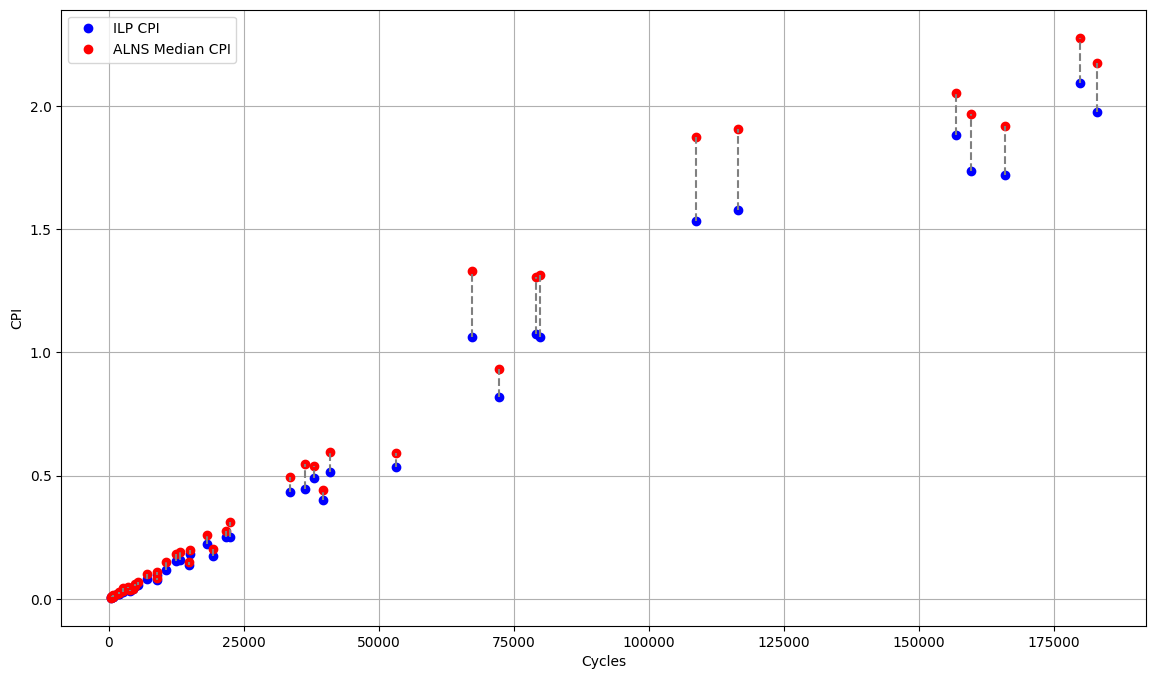

In [30]:
import matplotlib.pyplot as plt

# Ensure index is reset after filtering to avoid KeyError
filtered_df.reset_index(drop=True, inplace=True)

# Plot setup
plt.figure(figsize=(14, 8))

# Plot ILP CPI values
plt.plot(filtered_df['cycles'], filtered_df['ILP_CPI'], color='blue', marker='o', linestyle='none', label='ILP CPI')

# Plot ALNS 3rd Lowest CPI values
plt.plot(filtered_df['cycles'], filtered_df['ALNS3rd_Lowest_CPI'], color='red', marker='o', linestyle='none', label='ALNS Median CPI')

# Draw lines between ILP and ALNS points for each cycle
for i in range(len(filtered_df)):
    plt.plot([filtered_df['cycles'][i], filtered_df['cycles'][i]], 
             [filtered_df['ILP_CPI'][i], filtered_df['ALNS3rd_Lowest_CPI'][i]], 
             color='gray', linestyle='--')

# plt.xscale('log')
# Final plot adjustments
plt.xlabel('Cycles')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
ilp_pairs = parse_pairs(data['ilp-incumbent'][30])
alns_pairs = [parse_pairs(data[f'alns-{i}'][30]) for i in range(1, 6)]
print(alns_pairs)

[[(40.0, 54.716), (36.0, 138.638), (35.0, 182.854)], [(37.0, 51.812), (36.0, 82.405), (35.0, 260.119)], [(37.0, 50.584), (35.0, 69.893)], [(40.0, 53.625), (36.0, 125.929), (35.0, 416.509)], [(41.0, 51.55), (40.0, 70.299), (37.0, 153.319), (35.0, 300.386)]]


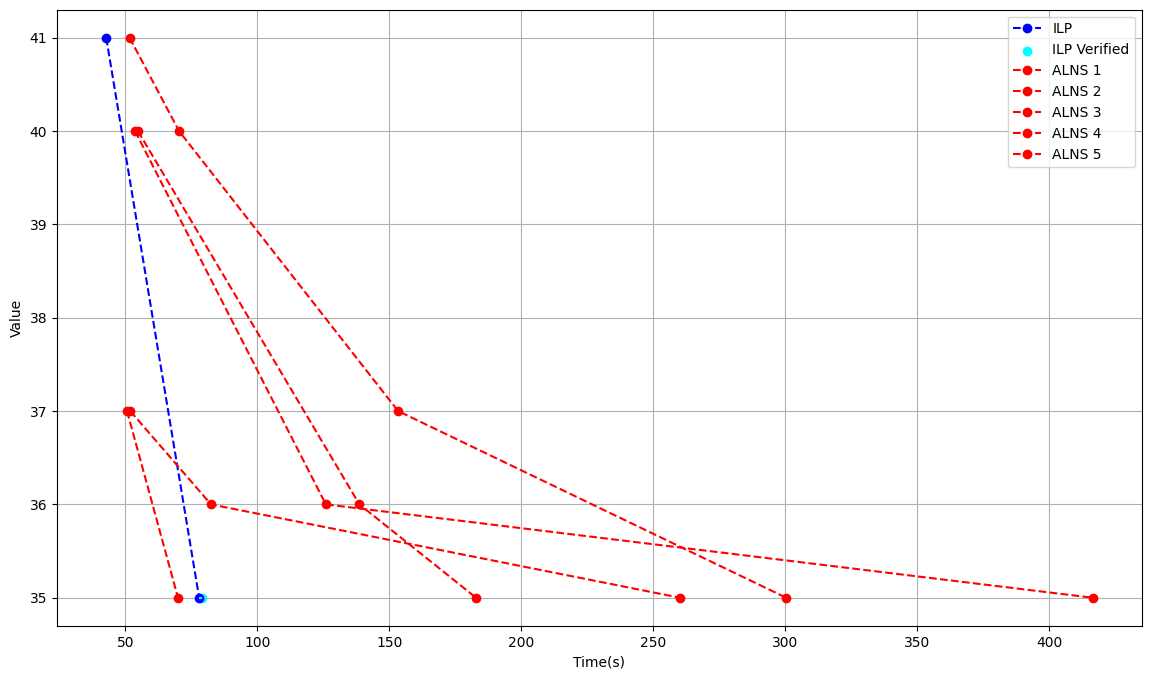

In [24]:
# Plot setup
plt.figure(figsize=(14, 8))
# Plot ILP pairs
ilp_times = [pair[1] for pair in ilp_pairs]
# ilp_times.append(float(data['ilp-solve-time'][0]))
ilp_values = [pair[0] for pair in ilp_pairs]
# ilp_values.append(float(data['ilp-min-fences'][0]))
plt.plot(ilp_times, ilp_values, color='blue', label='ILP', marker='o', linestyle='--')


# Add the last ILP point separately with a different color
last_ilp_time = float(data['ilp-solve-time'][30])
last_ilp_value = float(data['ilp-min-fences'][30])
plt.scatter([last_ilp_time], [last_ilp_value], color='cyan', label='ILP Verified', marker='o')

plt.plot([ilp_times[-1], last_ilp_time], [ilp_values[-1], last_ilp_value], color='cyan', linestyle='--')

# # Define colors for ALNS pairs
# alns_colors = ['red', 'green', 'purple', 'orange', 'brown']

# Plot each ALNS pair with different colors
for i, pairs in enumerate(alns_pairs):
    alns_times = [pair[1] for pair in pairs]
    alns_values = [pair[0] for pair in pairs]
    plt.plot(alns_times, alns_values, color='red', label=f'ALNS {i+1}', marker='o', linestyle='--')

# Final plot adjustments
plt.xlabel('Time(s)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()